In [1]:
# import cudf as pd
import pandas as pd
from pandarallel import pandarallel

pandarallel.initialize()

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
# df = pd.read_csv("llamacpp.llama8b.trace.3conversation_no_cachedrop.log)
df = pd.read_csv("llamacpp.llama8b.trace.1717683027-1talk.log")
df = df.dropna()

/tmp/ipykernel_558774/3675381577.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("llamacpp.llama8b.trace.1717683027-1talk.log")


In [3]:
df['time'] = df["time"].astype("int")
df["flags"] = df["flags"].astype("int").parallel_apply(lambda x: f"{bin(x)[2:]}".ljust(10, "0")).astype("str")
df["retval"] = df["retval"].astype("int").parallel_apply(lambda x: f"{hex(x)}").astype("str")

In [4]:
df

,pid,name,addr,flags,time,retval
0,419749,loginctl,(nil),0000000000,6683292317147089,0x200
1,419749,loginctl,(nil),0000000000,6683292317154689,0x200
2,419749,loginctl,(nil),0000000000,6683292317157779,0x200
3,419749,loginctl,(nil),0000000000,6683292317160519,0x200
4,419749,loginctl,(nil),0000000000,6683292317163629,0x200
...,...,...,...,...,...,...
1190149,3690126,systemd-journal,0x7f6af9cda598,1001010101,2490,0x4000
1190150,419658,bpftrace,0x55fa5b0559cc,1001010101,5830,0x0
1190151,419658,bpftrace,0x55fa5b24dff0,1001010100,25140,0x0
1190152,419658,bpftrace,0x55fa5b2d5650,1001010100,6740,0x0


In [5]:
df["name"].value_counts()

name
loginctl           629651
main               213726
sh                 128552
ps                  90307
grep                48207
node                19128
nft                 15271
rustdesk            11081
cpuUsage.sh          9693
tracker-extract      7209
cat                  4017
watch                3492
pool-tracker-mi      2376
systemd-journal      1919
sed                  1056
sudo                  632
which                 542
gdbus                 511
tracker-miner-f       496
systemd               463
sleep                 419
dbus-daemon           326
(xtract-3)            241
cpptools              166
polkitd               163
zsh                   115
bash                  112
cuda-EvtHandlr         80
bpftrace               69
gmain                  33
tailscaled             25
dconf worker           21
rshim                  17
pool-tracker-ex        15
in:imklog               6
coredns                 5
snapd                   4
gvfsd-metadata          3
cups-br

In [6]:
# 过滤掉其他附带的程序
df = df[df["name"] == "main"]
df = df.reset_index().drop(columns=["index"])

In [7]:
df["name"].value_counts()

name
main    213726
Name: count, dtype: int64

In [8]:
df["retval"].value_counts()

retval
0x100    90651
0x0      86754
0x400    18385
0x200    17468
0x404      465
0x300        3
Name: count, dtype: int64

# 虚拟地址转换成pfn

In [9]:
df["pfn"] = df["addr"].apply(lambda x: int(x, 16))
df["pfn"] = df["pfn"].parallel_apply(lambda x: (x - df["pfn"].min()) // (4 * 1024))
df["pfn"] = df["pfn"].astype("int")

In [10]:
df

,pid,name,addr,flags,time,retval,pfn
0,419754,main,0x5565db951468,1000010101,310626,0x404,22921699153
1,419754,main,0x5565db951468,1000110101,2670,0x200,22921699153
2,419754,main,0x7f37407a0110,1000010101,5420,0x200,34147118496
3,419754,main,0x7fffb5be3f09,1000010101,1960,0x0,34357314019
4,419754,main,0x7f3740785290,1101010100,3350,0x100,34147118469
...,...,...,...,...,...,...,...
213721,419754,main,0x7fffb5bdfe40,1001010101,8530,0x0,34357314015
213722,419754,main,0x7fffb5bdee40,1001010101,1059,0x0,34357314014
213723,419754,main,0x5565dce70cd0,1001010100,1950,0x0,22921704560
213724,419754,main,0x5565e40e4e10,1001010100,27829,0x0,22921733860


# Plot

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
bin(2)[2:]

'10'

<Axes: ylabel='pfn'>

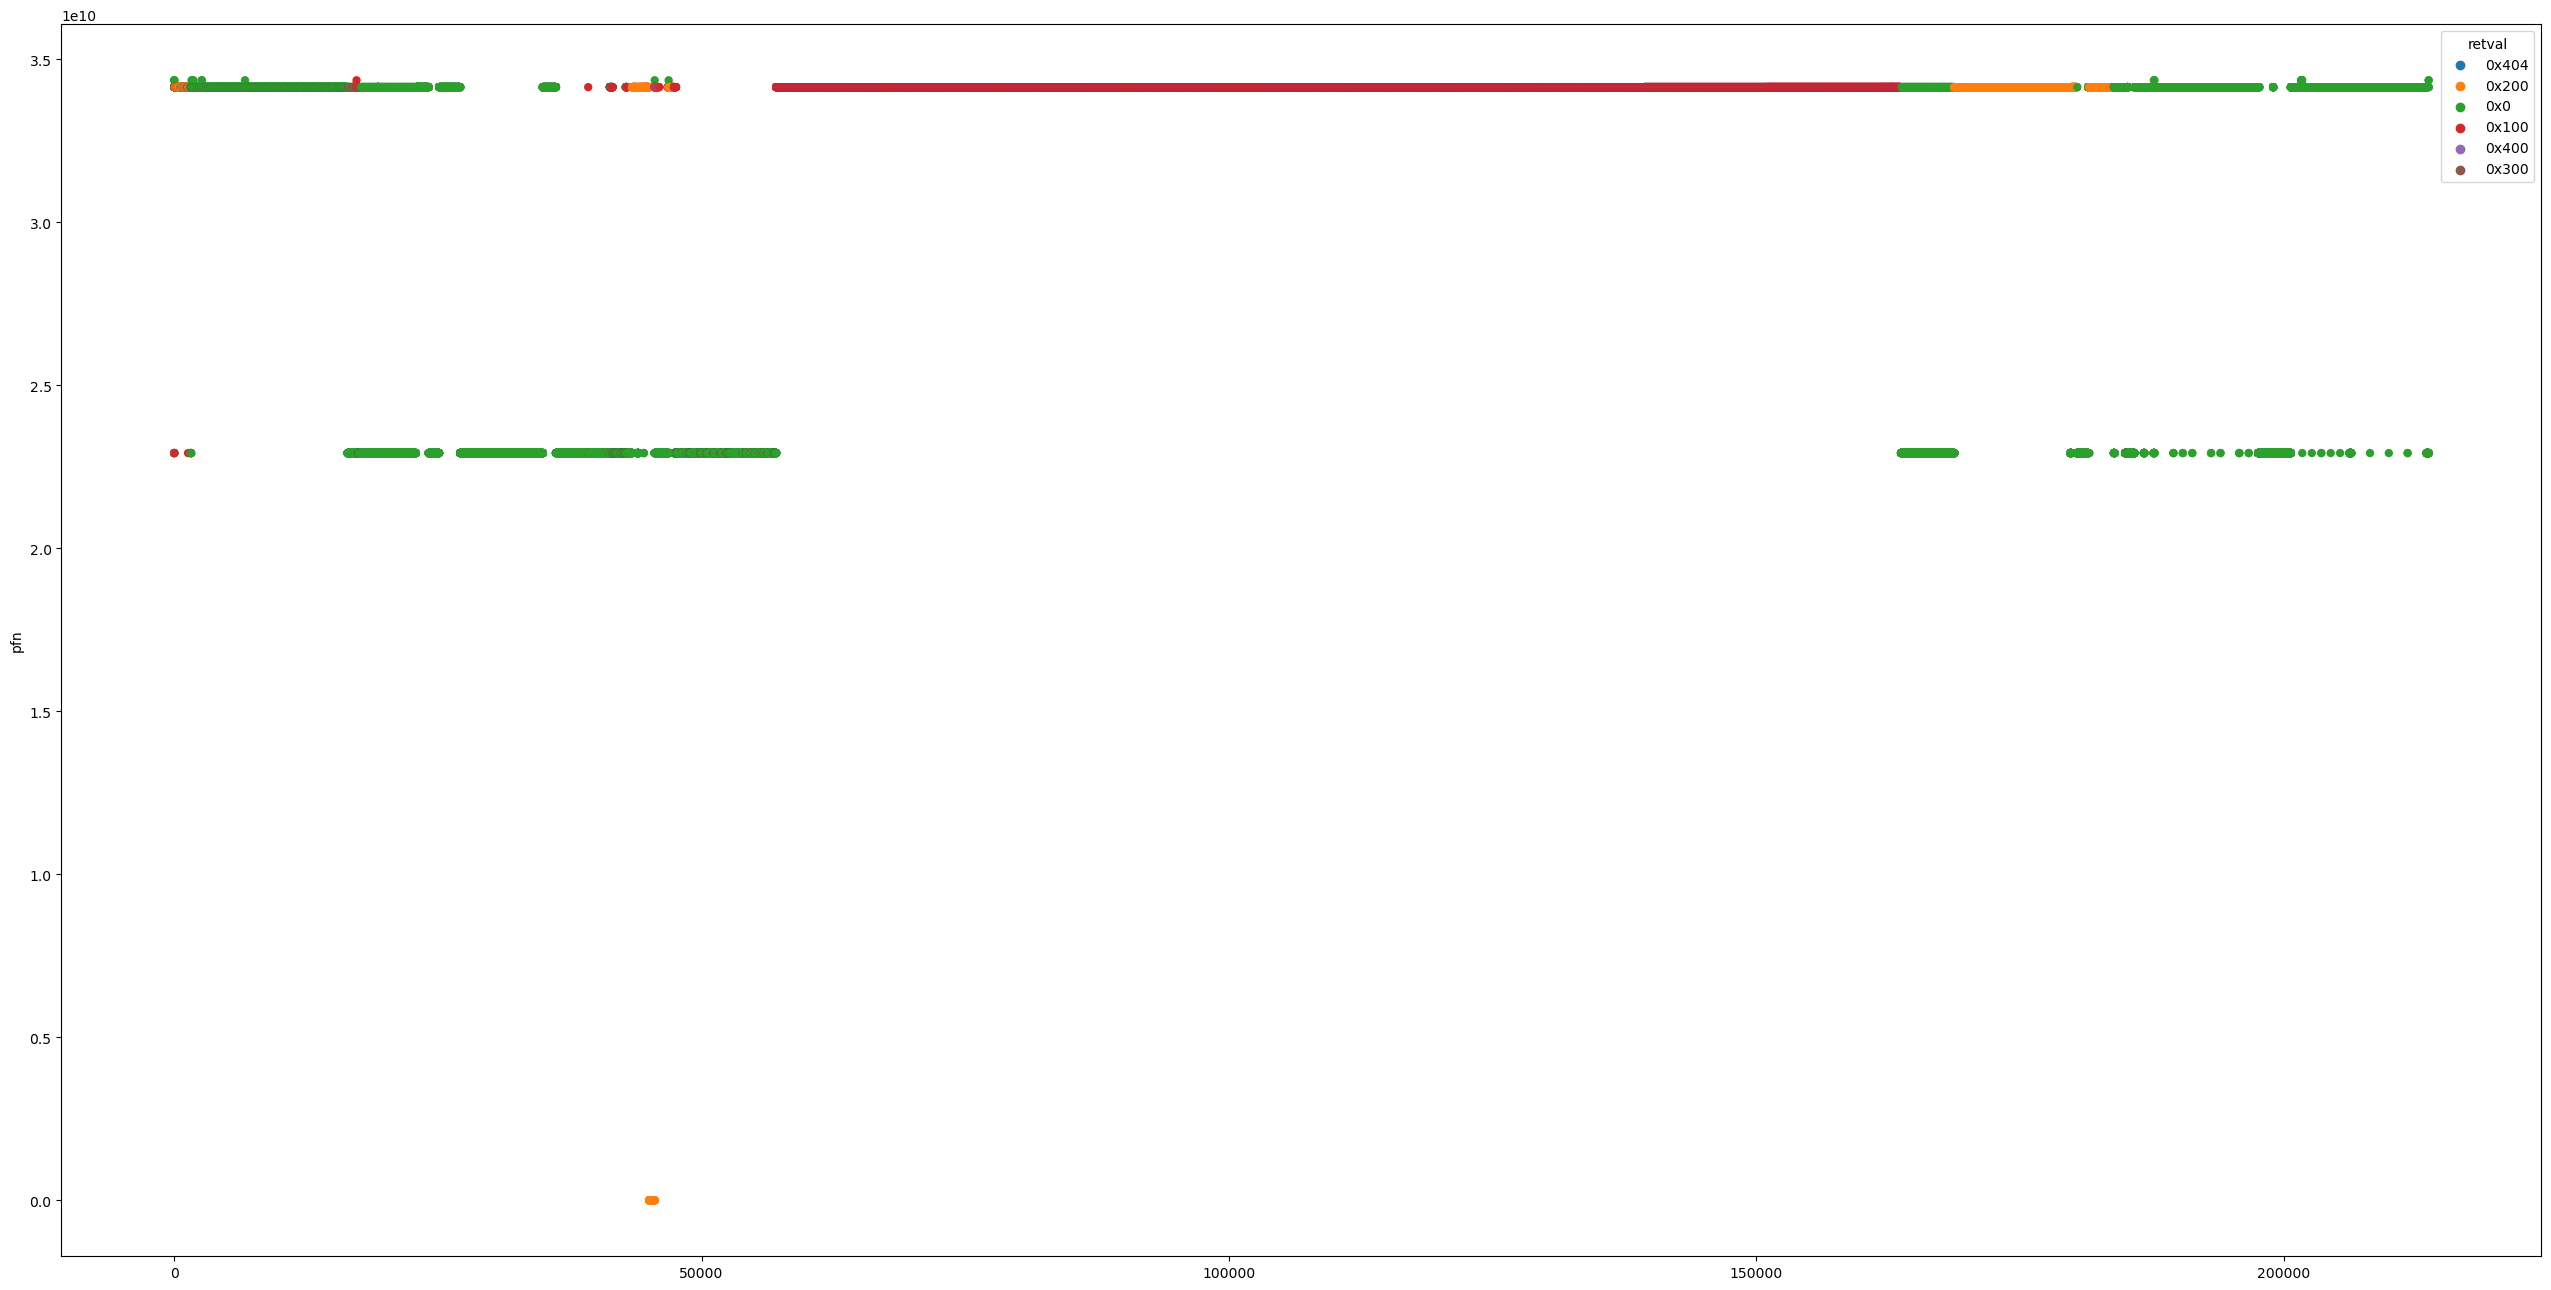

In [13]:
plt.figure(figsize=(32,16))
sns.scatterplot(x=range(len(df)), y=df['pfn'], hue=df["retval"], linewidth=0)

In [14]:
kernel_fault = df[df["pfn"] > 3e10]
user_fault = df[(1e10 < df["pfn"]) & (df["pfn"] <= 3e10)]

<Axes: ylabel='pfn'>

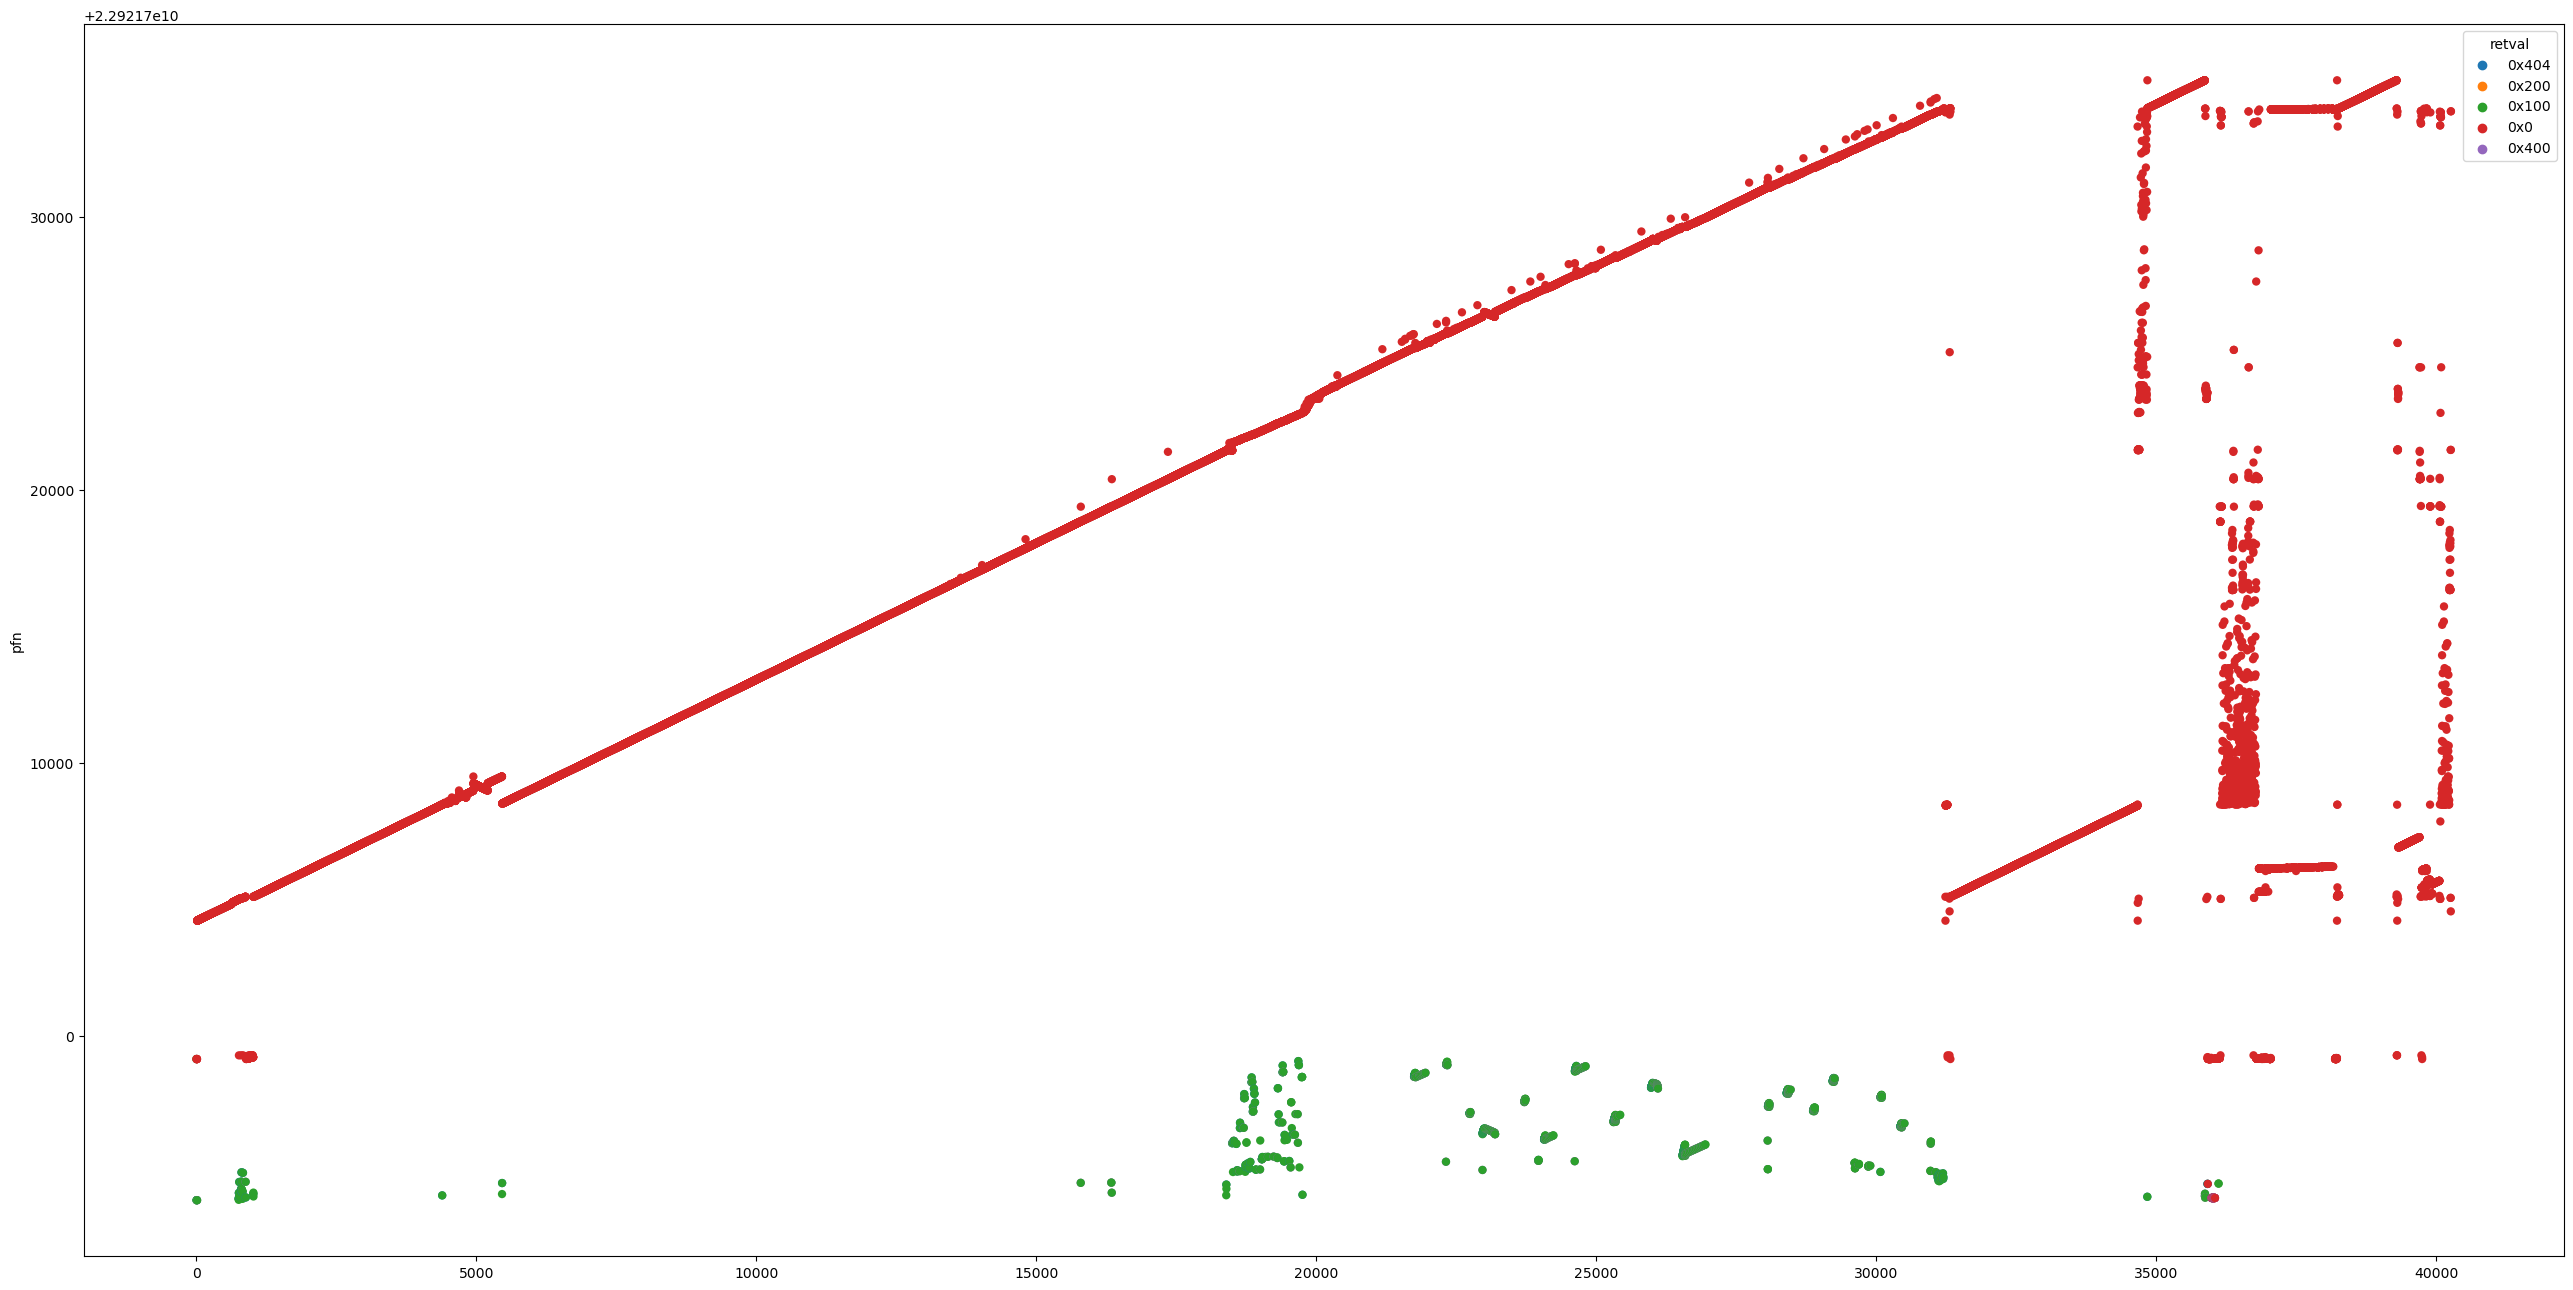

In [15]:
plt.figure(figsize=(32,16))
sns.scatterplot(x=range(len(user_fault)), y=user_fault['pfn'], hue=user_fault["retval"], linewidth=0)